# Feed calculator

In [410]:
import pandas as pd
from pulp import *

# Basic Model

## Process the dataset

In [411]:
pd.set_option('display.max_columns', 500) #To show all the columns when neccessary
df = pd.read_excel("nutrition.xlsx",nrows=64)

In [412]:
df.columns = ['ingredient' if col.startswith('INGREDIENT') else col for col in df]

In [413]:
food_items = list(df['ingredient'])

In [414]:
print("So, the food items to consdier, are\n"+"-"*100)
for f in food_items:
    print(f,end=', ')

So, the food items to consdier, are
----------------------------------------------------------------------------------------------------
barley, blood, boneash, copra, cotton, fats, fish, fishlq, gnseeds, gncake, maize, maizebranhighq, maizebranlowq, mbmeal, sugars, pkcake, palmoil, rapecake, rapemeal, rice, sesamecake, sorghum, soybeanexp, soybeanhulls, soybeanmeal, soybeanheat, sunflower, sunflowerseeds, tapbran, caswhole, casfine, cascoarse, wheat, wheatbran, dicaph, monocapo, lime, shells, salt, 

In [415]:
import numpy as np
df.shape

(39, 73)

In [416]:
np.random.seed(0)
# df['Price/kg'] = random.rand(39,1)*10
df['Price/kg'] = np.ones(39)*10

## Create dictionary of nutrition for all food items

In [417]:
nutrition_df=pd.read_excel('quantity.xlsx')

In [418]:
#Extract all the nutritions included
nutrition=[]
for i in range (len(nutrition_df)):
    nutrition.append(nutrition_df.iloc[i][0])
#Create dictionay for every single nutrition. The dictionary includes the amount contained in different ingredient.
for i in range(len(nutrition)):
    vars()[nutrition[i]] = dict(zip(food_items,df[nutrition[i]]))

## Dealing with costs

In [419]:
print(food_items)

['barley', 'blood', 'boneash', 'copra', 'cotton', 'fats', 'fish', 'fishlq', 'gnseeds', 'gncake', 'maize', 'maizebranhighq', 'maizebranlowq', 'mbmeal', 'sugars', 'pkcake', 'palmoil', 'rapecake', 'rapemeal', 'rice', 'sesamecake', 'sorghum', 'soybeanexp', 'soybeanhulls', 'soybeanmeal', 'soybeanheat', 'sunflower', 'sunflowerseeds', 'tapbran', 'caswhole', 'casfine', 'cascoarse', 'wheat', 'wheatbran', 'dicaph', 'monocapo', 'lime', 'shells', 'salt']


In [420]:
cost_df_raw=pd.read_excel('costs.xlsx')

In [421]:
food_items_df=pd.DataFrame(food_items,columns=['food'])

In [422]:
costs_df=food_items_df.merge(cost_df_raw,left_on='food',right_on='Ingredients')

In [423]:
costs_df=costs_df.drop('food',axis=1)

In [424]:
costs_df.head()

,Ingredients,Price
0,barley,105
1,blood,285
2,boneash,70
3,copra,65
4,cotton,80


In [425]:
costs={}
for i in range (len(costs_df)):
    costs[costs_df['Ingredients'].iloc[i]]=costs_df['Price'].iloc[i]

In [426]:
print(costs)
len(costs)

{'barley': 105, 'blood': 285, 'boneash': 70, 'copra': 65, 'cotton': 80, 'fats': 600, 'fish': 250, 'fishlq': 220, 'gnseeds': 235, 'gncake': 200, 'maize': 130, 'maizebranhighq': 75, 'maizebranlowq': 60, 'mbmeal': 135, 'sugars': 85, 'pkcake': 50, 'palmoil': 600, 'rapecake': 125, 'rapemeal': 87, 'rice': 45, 'sesamecake': 97, 'sorghum': 150, 'soybeanexp': 150, 'soybeanhulls': 30, 'soybeanmeal': 150, 'soybeanheat': 250, 'sunflower': 81, 'sunflowerseeds': 195, 'tapbran': 90, 'caswhole': 60, 'casfine': 70, 'cascoarse': 65, 'wheat': 110, 'wheatbran': 70, 'dicaph': 350, 'monocapo': 375, 'lime': 20, 'shells': 45, 'salt': 100}


39

# Extension 1-1

Question: At most MaxNum of ingredients to use. 

In [427]:
def cost_calculation(MaxNum,food_items,nutrition_df):
    #Extract all the nutritions included
    nutrition=[]
    for i in range (len(nutrition_df)):
        nutrition.append(nutrition_df.iloc[i][0])
    #Create dictionay for every single nutrition. The dictionary includes the amount contained in different ingredient.
    for i in range(len(nutrition)):
        vars()[nutrition[i]] = dict(zip(food_items,df[nutrition[i]]))
    
    food_vars = LpVariable.dicts("Portion",food_items,lowBound=0,cat='Continuous')
    
    food_chosen = LpVariable.dicts("Chosen",food_items,0,1,cat='Integer')
    
    prob2 = LpProblem("Smallholder Layer Starter Diet",LpMinimize)

    # The objective function is added to 'prob' first
    prob2 += lpSum([costs[i]*food_vars[i] for i in food_items]), "Total Cost of the balanced diet"

    for i in range(len(nutrition_df)):
        n = vars()[nutrition_df.iloc[i,0]]
        prob2 += lpSum([n[f]* food_vars[f] for f in food_items]) >= nutrition_df['Minimum'][i]
        if (i in nutrition_df[nutrition_df['Maximum']>0].index):
            prob2 += lpSum([n[f]* food_vars[f] for f in food_items]) <= nutrition_df['Maximum'][i]

    for f in food_items:
        prob2 += food_vars[f]>= 0

        prob2 += food_vars[f]<= food_chosen[f]*1e5
    prob2+= lpSum([food_chosen[f] for f in food_items])<=MaxNum
    # The problem is solved using PuLP's choice of Solver
    prob2.solve(pulp.PULP_CBC_CMD())

    return round(value(prob2.objective),2)

In [428]:
cost_vec=[]
MaxNumVec=[]
for MaxNum in range (3,12):
    cost=cost_calculation(MaxNum,food_items,nutrition_df)
    MaxNumVec.append(MaxNum)
    cost_vec.append(cost)

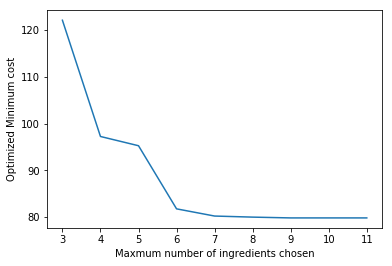

In [431]:
import matplotlib.pyplot as plt
plt.plot(MaxNumVec,cost_vec)
plt.ylabel('Optimized Minimum cost')
plt.xlabel('Maxmum number of ingredients chosen')
plt.show()

In [430]:
cost_vec

[122.11, 97.23, 95.25, 81.74, 80.2, 79.97, 79.8, 79.8, 79.8]